<style>
body {
        font-family: "Monaco", sans-serif;
}
</style> 
# Sherman lab RNAseq analysis pipeline
_by Tige Rustad
    Senior Scientist in the lab of David Sherman at SCRI
    Affiliate Assistant Professor in the UW Dept. of Global Health_

## Why use a Jupyter notebook


The purpose of this notebook is to walk through the analysis of RNAseq data for a paper I'm working on. Initially this Jupyter notebook was for me alone, a way for me to keep the code and notes for this bit of analysis organized. Then realized I could share this with people in our lab, David in particular, who might get a lot of insight from reading a Jupyter style notebook. I like the way I can walk you through my notes, methods, and the resulting tables and figures all in a single narrative. You can also try making changes to the code on the fly with no coding experience. 

Finally I realized I might be able to make this more broadly useful to the TB field, so I'm going to try to write this so that it is comprehensible to a general audience. 

I have taken this notebook and posted it to myBinder.com so that anyone can use it without having to install _anything_ on their computer other than an internet browser. That is so cool. You can also share this notebook with anyone who has Anaconda installed on their computer, so here are additional installation steps for users running this locally (instead of just looking at the contents on nbviewer or running it from myBinder.com).

You will need to to do the following steps:
1. Install the __[Anaconda python distribution](https://www.anaconda.com/distribution/)__. This will let you run all of the python scripts, pre-installs the most popular Python libraries, provides Jupyter notebook support, and, like BioConductor for R, is curated to maintain stability.
2. Install the Clustergrammer 'widget' so we can generate interactive heatmaps/dendograms.
    - First run the 'Anaconda prompt' to open a window where we can install new libraries
    - Then run the following commands:
        -  conda install -c conda-forge ipywidgets
        -  pip install --upgrade clustergrammer_widget
        -  jupyter nbextension enable --py --sys-prefix widgetsnbextension
        -  jupyter nbextension enable --py --sys-prefix clustergrammer_widget
3. The big one. This notebook is designed to be used with __[tidy datasets](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)__. That means each row is a different observation, in this case an RNAseq run, and each column is a different variable, here either the expression for a given gene or a column of metadata. 

 ***
This version of the notebook is focused on presenting the data from a specific experiment. 
I think I can make this more generally useful, a really Plug-n-Play RNAseq analysis pipeline that
can take any log-normal distributed type of data and get a good first pass understanding of what the data tells you.
Making that more generic tool will take more time, but if I seem to being doing things in a round-about fashion, 
that may be why.
 
I'm going to assume you know how to use Jupyter notebooks. If not, there are many good [basic intros to Jupyter notebooks](http://lmgtfy.com/?q=github+getting+started) on YouTube. 
***
This notebook was inspired by the excellent walkthrough of Seaborn plotting __[here](https://www.kaggle.com/mjbahmani/a-comprehensive-ml-workflow-with-python)__ and the __[Zika virus notebook](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4972086/)__ from the Ma'ayan lab, and when possible I simply borrowed code from those examples.  

## Table of contents

1. [Experimental design](#Experimental-design)
2. [Install](#Python-setup) python libraries
3. [Data import](#Data-import) and subtable generation
4. Set up [color palettes](#Colors)
5. Compare data to design- [sanity check](#Sanity-check)
 -  Clustergrammer of all samples or with replicates merged
 -  PCA plot of sample types

<a id = 'Experimental design'></a>

## Experimental design

These data come from an experiment testing the transcriptional impact of perturbing specific transcription factors of _Mycobacerium tuberculosis_ (Mtb), specifically in the context of a hypoxic time course. Oxygen limitation is an environmental stress that arrests growth, alters the drug susceptibility profile, and leads to a complex remodeling of the transcriptome that changes the expression of the majority of the Mtb genes. Hypoxia, or oxygen limitation, is a common in vitro model of Mtb in the latent phase of infection. 

A prior screen of all of the Mtb transcription factors (TFs) by us identified six TFs that were impaired in their ability to return to active growth when oxygen is returned after 7 days of hypoxia. We have dubbed this set of TFs the Critical Oxygen Response Regulators, or CORRs. 

#### Dataset variables

 - Strains: Each strain is carrying the same TF overexpression plasmid with the only difference being the insert
    - Rv0023  - a previously undescribed TF that triggers many of the expression changes triggered by hypoxia when induced
    -  Rv0081  - part of the initial hypoxic response, regulon also has large overlap with hypoxic response
    -  Rv0353  - HspR, regulator of the heat shock protein chaperones
    -  Rv1985c - Several proposed functions for this TF, none confirmed yet, deleted in the vaccine strain BCG
    -  Rv2788  - SirR, suggested role as regulator of manganese homeostasis and other stress responses
    -  Rv3416  - WhiB3, redox homeostasis regulator, described in multiple papers from Adrie Steyn
    -  Empty   - This strain carrys the same plasmid as the others, but there is no TF inserted

 - Hypoxia: Each strain was taken through a hypoxic time course that begins with log phase growth to hypoxia and reaeration
    -  Log
    -  Hypoxia
    -  Reaeration

 - Time: After the day 0 sample is taken the culuture is transfered to a flask that has a steady flow of nitrogen with 0.2% oxygen, roughly 1% of atmospheric.
    -  Day 0  - Log phase culture
    -  Day 2  - Hypoxia
    -  Day 4  - Hypoxia
    -  Day 7  - Hypoxia. Culture transfered to aerobic rolling flask
    -  Day 8  - Reaeration
    -  Day 9  - Reaeration
    -  Day 10 - Reaeration
    -  Day 11 - Reaeration
    -  Day 12 - Reaeration. Not present for some strains


#### More detail for people with less background in TB research and our prior experiments

The strains used in this experiment were made as part of a previous project. They all come from the lab strain H37Rv, often abbreviated 'Rv', and each strain is carrying a plasmid that allows us to induce the overexpression of one of the CORRs. These plasmids have the TF gene downstream of a strong promoter and the TetO operator, which is recognized by the TetR repressor. In the presence of the inducer (anhydrotetracycline or Atc) TetR is removed from the promoter and these strains begin expressing that TF from the plasmid in addition to the native copy in the genome. These TFs have varying levels of baseline expression, but in all cases the given TF becomes one of the most highly expressed genes in the genome. 

Also note that these TFs have been modified so that they carry a FLAG tag on their C' tail. We don't haven't found an example where the tail has any impact on the TF function, but it is certainly possible that in some cases that extra bit will interfere or modify DNA binding properties. Note- the FLAG tag was used in ChIP experiments to determine the DNA binding profile of each TF.

Transcription factors typically change their promoter affinity based on some secondary signal like a small molecule, modifications to the TF by another protein (e.g. phosphorylation by a kinase), or interaction with a partner protein. In this case however we are driving activation of these TFs by mass action, simply overcoming the weak interaction of the TF without the activating signal by generating an excess of TF, some of which will bind to and activate that gene's regulon. 

Activation of TFs by overexpression could lead to binding and activation of genes not normally regulated by that TF. It's also possible that the the TF may have some impact on the cell other than DNA binding, and these effects could lead to changes in gene expression. 

<a id = 'Python-setup'></a>

## Setup

### Import python libraries and initialize global style settings. 

In [1]:
## import all required python libraries

from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.decomposition import PCA
from clustergrammer2 import net
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn    
import scipy      
import numpy
import time
import json
import sys
import csv
import os

clustergrammer2 backend version 0.2.10


In [2]:
## style settings for seaborn, pylab, and matplotlib
sns.set(style='white', context='notebook', palette='deep')

## set so figures show up in the notebook just below the code block
%matplotlib inline

## limit output to 20 lines
pd.set_option('display.max_rows', 20)

<a id = 'Data-import'></a>

# Import data
In the future I'd like to add the ability to start with raw FASTQ files straight from the sequencers, but that'll take time and I'd rather finish a working version of this notebook first, so we will start with data that has been processed to generate read counts for each gene.

We start by loading the RNAseq data into a pandas data frame. Remember that the data being imported __must__ be in 'tidy' format, which makes the importing part so smooth. The python library 'pandas' is is a very useful way of storing data in spreadsheet-like 'panel data', thus the name. Then we will break this table into a subtable with just data and a subtable with metadata.

In [3]:
## import data from a csv file and use the first row as indices, or row names
df = pd.read_csv("./data/CORRtable.csv", index_col=0)

## use the name of the first column of data to find its index
FIRST_DATA_COL = df.columns.get_loc('Rv0001')

## Check the size and show a sample of the imported data
sample_num, obs_num = df.shape
print (f"This data set is comprised of {sample_num} RNAseq samples, each with {obs_num} variables")
df.iloc[:5,:8]

This data set is comprised of 186 RNAseq samples, each with 4033 variables


,Strain,Day,Oxygen,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,Day00,Log phase,334.459190,181.658442,147.731931,172.418119,1630.577360
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,Day00,Log phase,292.732004,215.371999,141.893519,162.957084,987.030751
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,Day00,Log phase,315.227327,251.792816,139.884214,165.348984,1087.433218
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,Day00,Log phase,471.729426,253.429217,124.371933,113.724922,1193.932203
EmptyPlasmid_D2_H5_R1,EmptyPlasmid,Day02,Hypoxia,42.430879,28.174870,22.553913,38.081986,400.565714


***
The first three columns of data contain meta-information about these samples (Strain, Day, and Oxygen) and the remaining columns show the count of reads that align to the given gene per million reads total, or CPM.

Later on we will want to refer to just the data or just the metadata, so let's create those subtables.

In [4]:
## split the 'df' dataframe into data and metadata
data = df.iloc[:,FIRST_DATA_COL:]
meta = df.iloc[:,:FIRST_DATA_COL]

## take a look at the resulting tables to make sure they look right.
print ("Data table shape:",data.shape)
print ("Meta(data) table shape:",meta.shape)

meta.iloc[:10,:]

Data table shape: (186, 4030)
Meta(data) table shape: (186, 3)


,Strain,Day,Oxygen
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,Day00,Log phase
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,Day00,Log phase
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,Day00,Log phase
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,Day00,Log phase
EmptyPlasmid_D2_H5_R1,EmptyPlasmid,Day02,Hypoxia
EmptyPlasmid_D2_H6_R2,EmptyPlasmid,Day02,Hypoxia
EmptyPlasmid_D2_H7_R3,EmptyPlasmid,Day02,Hypoxia
EmptyPlasmid_D2_TC6_R1,EmptyPlasmid,Day02,Hypoxia
EmptyPlasmid_D4_H5_R1,EmptyPlasmid,Day04,Hypoxia
EmptyPlasmid_D4_H6_R2,EmptyPlasmid,Day04,Hypoxia


<a id = 'Colors'></a>

## Set up color palettes

Now we inspect each column of metadata, look at how the data groups, and create a custom color palette for each type of metadata that we can use a consistent color scheme for all of the plots below.  

We first create vectors containing each element of metadata for use as categories and set up a color palette for each. 

In [5]:
## for each metadata column create a list with each variable for each sample and a list with all unique values
strain = df['Strain']
unique_strain = np.unique(strain)
day = df['Day']
unique_day = np.unique(day)
oxygen = df['Oxygen']
unique_oxygen = np.unique(oxygen)

## print out the list of unique meta-data values
print(unique_strain)
print(unique_day)
print(unique_oxygen)

['EmptyPlasmid' 'Rv0023' 'Rv0081' 'Rv0353' 'Rv1985c' 'Rv2788' 'Rv3416']
['Day00' 'Day02' 'Day04' 'Day07' 'Day08' 'Day09' 'Day10' 'Day11' 'Day12']
['Hypoxia' 'Log phase' 'Reaearation']


We can now assign colors to each unique value to make it easier to have consistent plots. I've made two ways to set the colors. You can either go with the preset palette's below or use interactive sliders to set the colors to your liking. Keep in mind that if you run a second one of these code boxes you will overwrite the first.

In [ ]:
## interactive selection of palettes

## strain palette
print(f"You'll want to set the number of colors to the number of unique strains: _{len(unique_strain)}_.")
strain_pal = sns.choose_colorbrewer_palette('q')

## day palette
print(f"You'll want to set the number of colors to the number of timepoints sampled _{len(unique_day)}_.")
day_pal = sns.choose_colorbrewer_palette('q')

## oxygen palette
print(f"You'll want to set the number of colors to _{len(unique_oxygen)}_.")
oxygen_pal = sns.choose_colorbrewer_palette('q')

## lastly lets pick out a color scheme for the heatmap
print("Heatmap color spectrum")
hmap_col = sns.choose_cubehelix_palette()

In [6]:
## alternative static selection of palettes
## **this will overwrite the interactive palette!**
## if you're curious about other colors from this palette you can find them all here : https://xkcd.com/color/rgb/

## strain palette
strain_pal = sns.color_palette("Set1",len(unique_strain))

## day palette
day_pal = sns.color_palette("Set2",len(unique_day))

## oxygen palette
oxygen_pal = sns.xkcd_palette(["windows blue", "amber", "dusty purple"])

## heatmap palette
hmap_col = sns.cubehelix_palette(8, start=.5, rot=-.75)

In [7]:
## let's make a function that plots a quick barplot showing each value and the color assigned to it
def paltest (values, test_pal):
    paltest = pd.DataFrame(index = values)
    paltest['test']=1
    plt.subplots(figsize = (1,len(values)))
    sns.barplot(y=paltest.index, x=paltest.test, palette = test_pal)

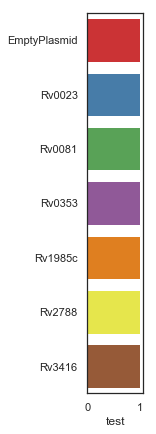

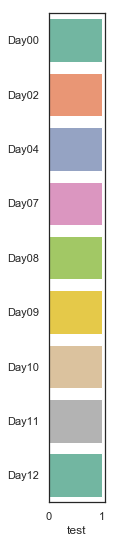

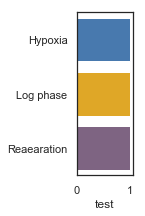

In [8]:
## show each palette 
## there is a bug somewhere preventing me from plotting these side by side 
paltest(unique_strain,strain_pal)
paltest(unique_day,day_pal)
paltest(unique_oxygen,oxygen_pal)


In [9]:
## once color map is selected, we make a 'look-up-table' that tells us what color to map to each value
## then use that lut to map each color back to the matching strains.
strain_lut = dict(zip(unique_strain, strain_pal))
strain_cols = pd.Series(strain).map(strain_lut)

day_lut = dict(zip(unique_day, day_pal))
day_cols = pd.Series(day).map(day_lut)

oxygen_lut = dict(zip(unique_oxygen, oxygen_pal))
oxygen_cols = pd.Series(oxygen).map(oxygen_lut)

<a id = 'Sanity-check'></a>

## Sanity check- does the data look 'right'

The first thing I do with any dataset like this is do a sanity check to see if the data looks like I expect, given the experimental design. First we'll check how well the replicates cluster using heatmaps and PCA to get two different views of the same data. 

In [10]:
## generate the distance matrix 
dists = pdist(data, 'correlation')

## take those distances and convert the vector into a square 
col_ident_mat = pd.DataFrame(squareform(dists), index=df.index, columns=df.index)

## make a single table with all of the metadata colors together to use as the label colors
colors = pd.DataFrame(strain_cols).join(pd.DataFrame(day_cols)).join(pd.DataFrame(oxygen_cols))

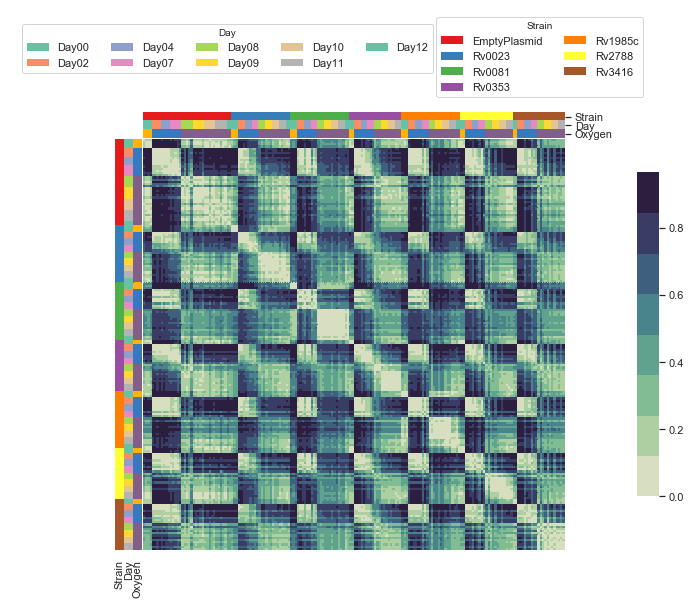

In [12]:
## Plot out all of the samples in a single identity correlation map
g = sns.clustermap(col_ident_mat,
                   # Turn off the clustering
                   row_cluster=False, col_cluster=False,

                   # Add colored class labels
                   row_colors = colors,
                   col_colors = colors,
                   # Make the plot look better when many rows/cols
                   linewidths=0, xticklabels=False, yticklabels=False,

                   # use the color scheme selected above for the heatmap
                   cmap = hmap_col
                  )
## draw the legend bar for the classes                 
for label in df['Day'].unique():
    g.ax_col_dendrogram.bar(0, 0, color=day_lut[label],
                            label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='Day', loc="center", ncol=5, bbox_to_anchor=(0.2, 0.6))    

for label in df['Strain'].unique():
    g.ax_row_dendrogram.bar(0, 0, color=strain_lut[label],
                            label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Strain', loc="right", ncol=2, bbox_to_anchor=(6, 1.2))
    
## adjust the postion of the main colorbar for the heatmap
g.cax.set_position([1, .2, .03, .45])


This is a little too busy to see clearly, so we will break this up into seperate correlation matrices for each strain.

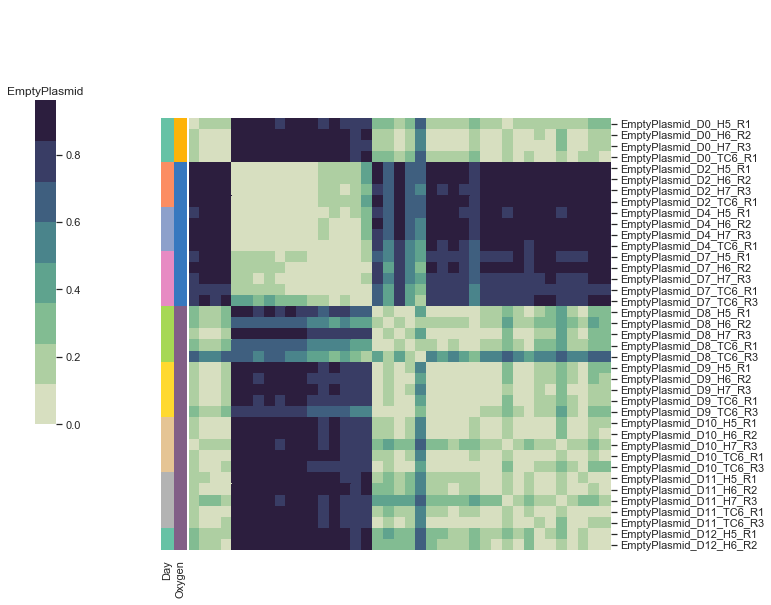

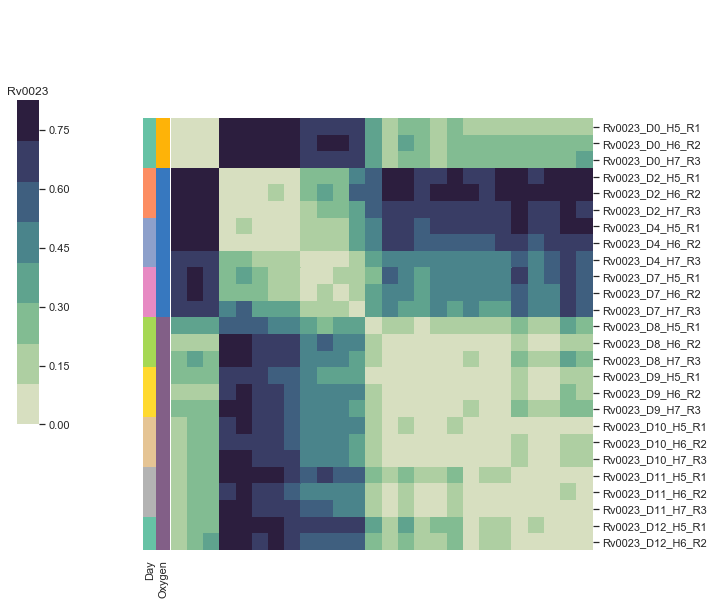

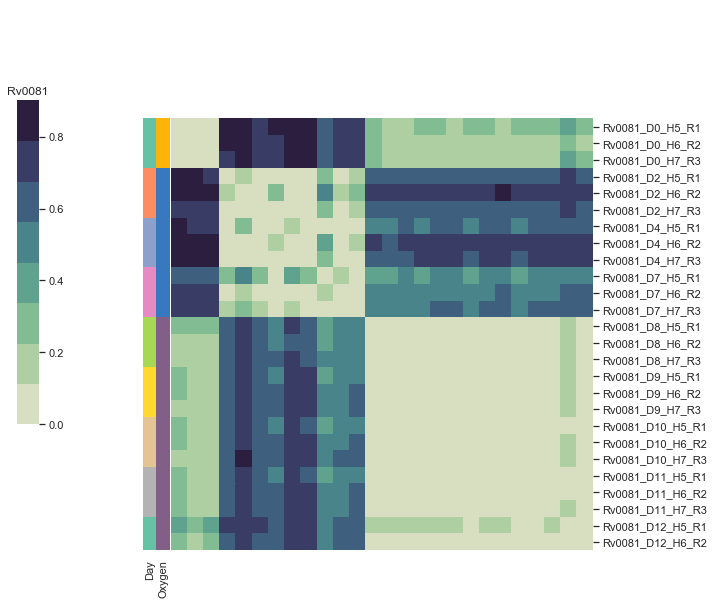

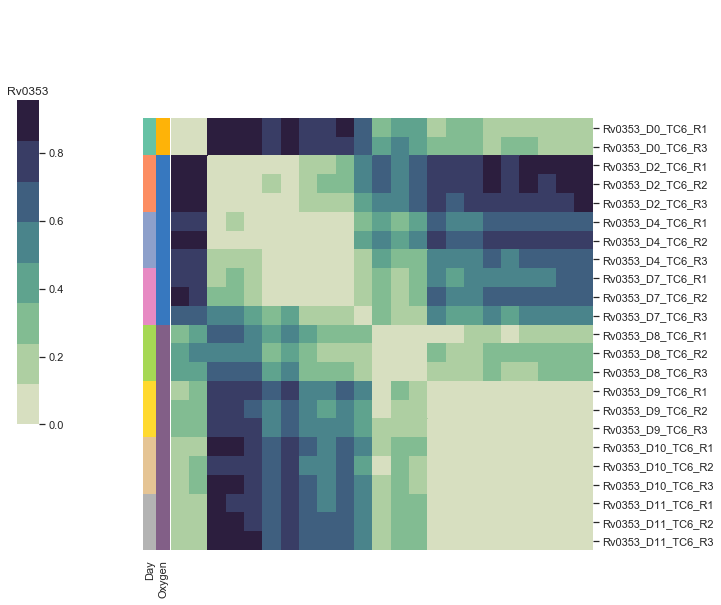

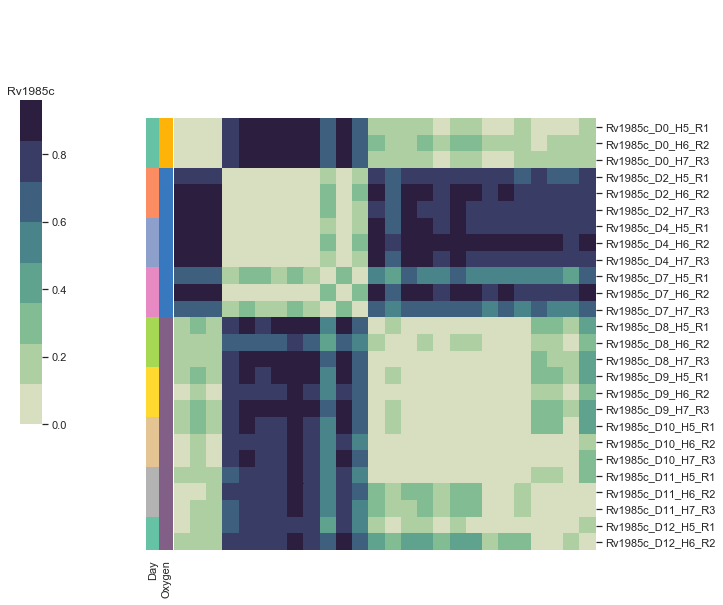

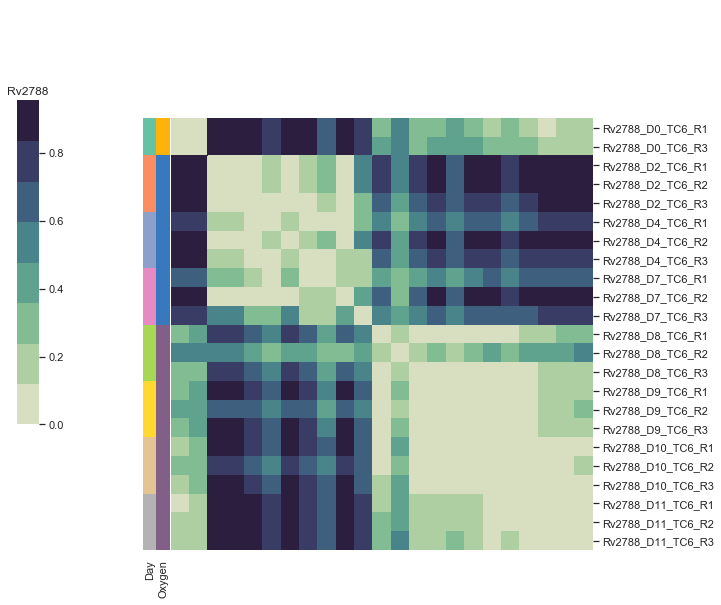

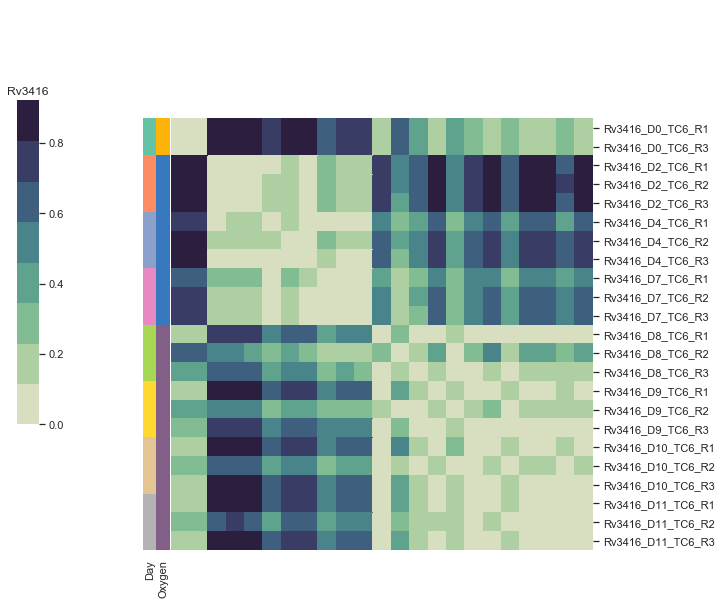

In [16]:
colors = pd.DataFrame(day_cols).join(pd.DataFrame(oxygen_cols))
for ustrain in unique_strain:
    sset = df.loc[df['Strain']== ustrain]
    ## generate the distance matrix, slicing off the metadata 
    ssdists = pdist(sset.iloc[:,FIRST_DATA_COL:], 'correlation')
    col_ident_mat = pd.DataFrame(squareform(ssdists), index=sset.index)
   
    g = sns.clustermap(col_ident_mat,
                   # Turn off the clustering
                   row_cluster=False, col_cluster=False,

                   # Add colored class labels
                   row_colors = colors,                        
                   # Make the plot look better when many rows/cols
                   linewidths=0, xticklabels=False, yticklabels=True,

                   # use the color scheme selected above for the heatmap
                   cmap = hmap_col
                      )
    plt.title(ustrain)
    g.cax.set_position([.1, .3, .03, .45])  

Generally, the replicates look like each other, the log phase looks like reaeration, and the hypoxic timepoints look like each other. There are other interesting patterns here. Look at the plot for the strain overexpressing Rv3416, just above. Notice the banding pattern in the reaeration samples. It looks like one of the replicates (R2) has reaeration expression profiles that look more like hypoxia than the other replicates. We could eliminate that sample as an outlier, but for now I will leave it there and just keep that variation in mind when interpreting the data below.

Now let's collapse the replicates, and then convert to log base 2. Why do I do this? Expression data has a log-normal distribution, so it's simpler to plot and understand the data in a log scale. There is nothing magical about a two-fold difference of course, but in my experience even under the best of conditions with minimal noise changes less than two fold are rarely significant. So, having log base 2 means that we can easily see two fold steps in expression.

In [17]:
## average replicates, convert to log base 2, and round to two significant digits
logdata = df.groupby(['Strain', 'Day']).mean()
logdata = np.log2(logdata)
logdata = np.round(logdata, decimals=2)

In [20]:
## when you add a '.loc' to the end of a Dataframe you pull data from a specific location
## here I want the expression of the gene Rv0023, and 
## I want to see that gene's expression over time in the Empty Plasmid and Rv0023 overexpressing strains
logdata.loc[['EmptyPlasmid','Rv0023'],'Rv0023'].unstack()
## the .unstack() makes the data easier to read- try it with and without if you'd like

Day,Day00,Day02,Day04,Day07,Day08,Day09,Day10,Day11,Day12
Strain,,,,,,,,,
EmptyPlasmid,6.08,6.25,6.26,6.01,5.87,5.65,5.81,5.54,5.15
Rv0023,14.06,10.59,10.55,10.90,12.39,12.02,11.51,10.76,9.94


## Interactive heatmap - Clustergrammer

This tool by the Ma'ayan lab creates a heatmap that is amazingly easy to use. At least on my computer it has problems with looking at more than a dozen arrays at a time, so here I'll first collapse the replicates and then use Clustergrammer to look at the genes with the largest differences between samples. 

In [25]:
help(net.filter_N_top)

Help on method filter_N_top in module clustergrammer2.clustergrammer_fun:

filter_N_top(inst_rc, N_top, rank_type='sum') method of clustergrammer2.clustergrammer_fun.Network instance
    Filter the matrix rows or columns based on sum/variance, and only keep the top
    N.



In [22]:
net.load_df(logdata)
#net.load_file('./data/CORRtable2.txt')       # this file is in the 'clustergrammer' format and lets me skip the data munging 

net.filter_N_top(inst_rc='row', N_top=200, rank_type='var')
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "Rv0023-11", "ini": 60, "clust": 50, "rank": 0, "rankvar": 59, …

In [ ]:
# convert df in Clustergrammer format
df2 = df.T
newlabs = df2.loc['Oxygen',:].add_prefix('Oxygen: ')
df2.loc['Oxygen',:]=newlabs
# check the size and type of the imported data
df2.head()

In [27]:

# normalize values to z-scores (i.e. how many st dev from the mean)
net.normalize(axis='row', norm_type='zscore')

# cluster using default parameters
net.widget()


ExampleWidget(network='{"row_nodes": [{"name": "Rv0023-11", "ini": 60, "clust": 50, "rank": 0, "rankvar": 59, …

## PCA plot to get another view of sample clustering

In [28]:
# First we will generate a PCA plot to collapse all of the gene expression values (dimensions) in a way that maximizes difference between samples
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(logdata)
elapsed = time.time()-time_start
print ("PCA done! Time elapsed:",elapsed," seconds")

PCA done! Time elapsed: 0.056967735290527344  seconds


Now let's make a function to plot the data from PCA (and later tSNE) plots

Now we collect the PCA data into a new data frame for plotting and calculate how much of the sample variance can be described by each component.

In [29]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ("Variance explained per principal component: ", pca.explained_variance_ratio_)

Variance explained per principal component:  [0.63438249 0.1007459  0.05328926 0.03645634]


In [56]:
## turn the indices of the logdata table into columns of metadata
logmeta = logdata.reset_index().iloc[:,:2]

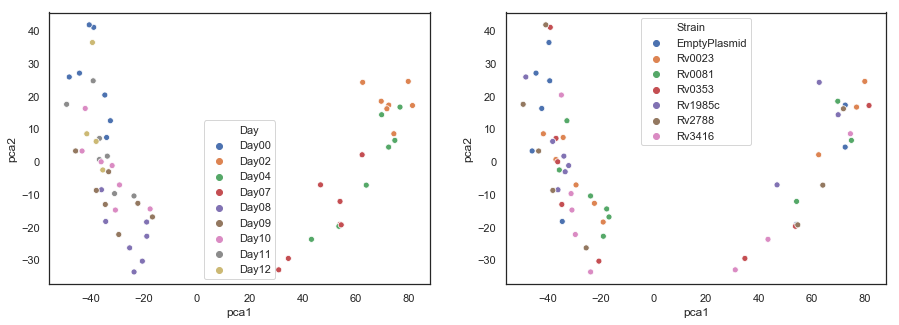

In [67]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(x = pca_df['pca1'], y = pca_df['pca2'], hue = logmeta['Day']) # Visualizing the PCA output
plt.subplot(122)
sns.scatterplot(x = pca_df['pca1'], y = pca_df['pca2'], hue = logmeta['Strain']) # Visualizing the PCA output
plt.show()

C:\Users\trust\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\trust\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    a MATLAB-like way of plotting.
    
    pyplot is mainly intended for interactive plots and simple cases of programmatic
    plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The object-oriented API is recommended for more complex plots.

FUNCTIONS
    acorr(x, *, data=None, **kwargs)
        Plot the autocorrelation of *x*.
        
        Parameters
        ----------
        
        x : sequence of scalar
        
        detrend : callable, optional, default: `mlab.detrend_none`
            *x* is detrended by the *detrend* callable. Default is no
            normalization.
        
        normed : bool, optional, default: True
            If ``True``, input vectors are normalised 

C:\Users\trust\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
